In [70]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/istanbul_data_preprocessed.csv')

name_cols = ['MainDistID', 'DistID', 'HcoID', 'SkuID']
categorical_cols = ['SalesRegionID_x','SalesRegionID_y', 'HcoType', 'District', 'Status', ]
numerical_cols = ['PaidQty', 'FGQty', 'TotalQuantity']
boolean_cols = ['IsReturn', 'IsMrsOrder']
data['Date'] = pd.to_datetime(data['Date'])

# convert categorical columns to 'category' data type
for col in categorical_cols:
    data[col] = data[col].astype('category')

# convert numerical columns to 'int' data type
for col in numerical_cols:
    data[col] = data[col].astype('int')
    
# convert name columns to str data type
for col in name_cols:
    data[col] = data[col].astype(str)
    
# convert boolean columns to 'bool' data type
for col in boolean_cols:
    data[col] = data[col].astype(bool)
    
raw_data = data.copy()

In [71]:
# find MainDistID, DistID, HcoID, SalesRegionID_x, SalesRegionID_y number of unique values and create dataframe

unique_values = pd.DataFrame(raw_data.nunique(), columns=['Number of Unique Values'])
unique_values = unique_values.loc[['DistID', 'MainDistID', 'HcoID', 'SalesRegionID_x', 'SalesRegionID_y', 'District']]

unique_values

,Number of Unique Values
DistID,63
MainDistID,20
HcoID,5974
SalesRegionID_x,120
SalesRegionID_y,120
District,82


## Top 5 DistID with the highest TotalQuantity

In [72]:
dist_total_quantity = raw_data.groupby('DistID').agg({'TotalQuantity': 'sum'}).sort_values(by='TotalQuantity', ascending=False).head(5)
dist_total_quantity

,TotalQuantity
DistID,
2878817,5316099
2878856,2181228
2878809,1756165
2878859,1592056
2878812,1290500


## Top 5 DistID with the highest TotalQuantity for seceleced SKU's

### Choosen SKU's
- I. Segment: 568 (challenge olan), 578, 1050
- II. Segment: 319 (en stabil olan), 509/615, 1018 (düşük satışlı olan)

In [73]:
segment_1_sku_ids = ["568", "578", "1050"]
segment_2_sku_ids = ["319", "509", "615", "1018"]

all_sku_ids = ["319"]

data = data[data['SkuID'].isin(all_sku_ids)]

dist_total_quantity = data.groupby('DistID').agg({'TotalQuantity': 'sum'}).sort_values(by='TotalQuantity', ascending=False).head(5)
dist_total_quantity

,TotalQuantity
DistID,
2878817,162651
2878856,63156
2878809,50628
2878845,47795
2878859,47176


In [74]:
highest_dist_ids = ['2878817', '2878856', '2878809', '2878845', '2878859']
highest_dist_data = data[data['DistID'].isin(highest_dist_ids)]

highest_dist_data

,MainDistID,DistID,Date,HcoID,SalesRegionID_x,BrandID,SkuID,IsReturn,PaidQty,FGQty,IsMrsOrder,HcoType,District,SalesRegionID_y,Status,TotalQuantity
568,2879266,2878856,2019-12-29,2860455,340502,15,319,False,1,0,False,P,BAKIRKÖY,340502,Active,1
923,2879266,2878856,2020-12-04,2860455,340502,15,319,False,1,0,False,P,BAKIRKÖY,340502,Active,1
3693,2879266,2878856,2020-05-27,2862317,340302,15,319,False,2,0,False,P,BAĞCILAR,340302,Active,2
3745,2879266,2878856,2020-07-27,2862317,340302,15,319,False,2,0,False,P,BAĞCILAR,340302,Active,2
3891,2879266,2878856,2020-11-24,2862317,340302,15,319,False,3,0,False,P,BAĞCILAR,340302,Active,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200324,2879266,2878859,2021-12-03,2924903,1000000,15,319,False,2,0,False,P,Sultangazi,1000000,Active,2
4200333,2879266,2878859,2021-12-29,2924903,1000000,15,319,False,3,0,False,P,Sultangazi,1000000,Active,3
4200372,2879266,2878859,2021-12-04,2924983,1000000,15,319,False,3,0,False,P,Sultangazi,1000000,Active,3
4200455,2879266,2878859,2021-12-28,2925223,1000000,15,319,False,5,0,False,P,Sultangazi,1000000,Active,5


# Quarterly & Monthly Sales Analysis and Forecasting for MainDistID & DistID

In this notebook, we will analyze the quarterly and monthly sales data of the choosen SKU's for Istanbul. We will use the Exponential Smoothing, Moving Average, Naive, Triple Exponential Smoothing, ARIMA, and SARIMA forecasting methods to forecast the sales of the choosen SKU's for the next 4 quarters and 4 months.

### Choosen SKU's
- I. Segment: 568 (challenge olan), 578, 1050
- II. Segment: 319 (en stabil olan), 509/615, 1018 (düşük satışlı olan)

In [75]:
segment_1_sku_ids = ["568", "578", "1050"]
segment_2_sku_ids = ["319", "509", "615", "1018"]

all_sku_ids = ["319"]

data = data[data['SkuID'].isin(all_sku_ids)]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206690 entries, 7 to 4201048
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   MainDistID       206690 non-null  object        
 1   DistID           206690 non-null  object        
 2   Date             206690 non-null  datetime64[ns]
 3   HcoID            206690 non-null  object        
 4   SalesRegionID_x  206690 non-null  category      
 5   BrandID          206690 non-null  int64         
 6   SkuID            206690 non-null  object        
 7   IsReturn         206690 non-null  bool          
 8   PaidQty          206690 non-null  int64         
 9   FGQty            206690 non-null  int64         
 10  IsMrsOrder       206690 non-null  bool          
 11  HcoType          206690 non-null  category      
 12  District         205359 non-null  category      
 13  SalesRegionID_y  206690 non-null  category      
 14  Status           206690 

# MainDistID Sales Analysis

Calculate the total sales of the choosen SKU's for quarterly and monthly.


++++++++

## Quarterly Sales Analysis

Calculate the total sales of the choosen SKU and MainDistID for quarterly. It should be 12 rows in total for every SKU and MainDistID.

In [76]:
main_dist_data_quarterly = data.copy()
main_dist_data_quarterly['Year'] = main_dist_data_quarterly['Date'].dt.year
main_dist_data_quarterly['Quarter'] = main_dist_data_quarterly['Date'].dt.quarter

main_dist_data_quarterly = main_dist_data_quarterly.groupby(['Year', 'Quarter', 'MainDistID', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
main_dist_data_quarterly

,Year,Quarter,MainDistID,SkuID,TotalQuantity
0,2019,1,2879231,319,763
1,2019,1,2879236,319,554
2,2019,1,2879243,319,149
3,2019,1,2879244,319,8
4,2019,1,2879249,319,11532
...,...,...,...,...,...
129,2021,4,2879266,319,31130
130,2021,4,2879276,319,984
131,2021,4,2886479,319,461
132,2021,4,2915715,319,7853


In [77]:
def plot_sku_main_dist(sku_id):
    sku_data = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == sku_id]
    sku_data['YearQuarter'] = sku_data['Year'].astype(str) + '-Q' + sku_data['Quarter'].astype(str)
    pivot_table = sku_data.pivot(index='YearQuarter', columns='MainDistID', values='TotalQuantity')
    pivot_table.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.title(f'Sales of SKU {sku_id} by MainDistID over Time')
    plt.xlabel('Year-Quarter')
    plt.ylabel('Total Quantity Sold')
    plt.legend(title='MainDistID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

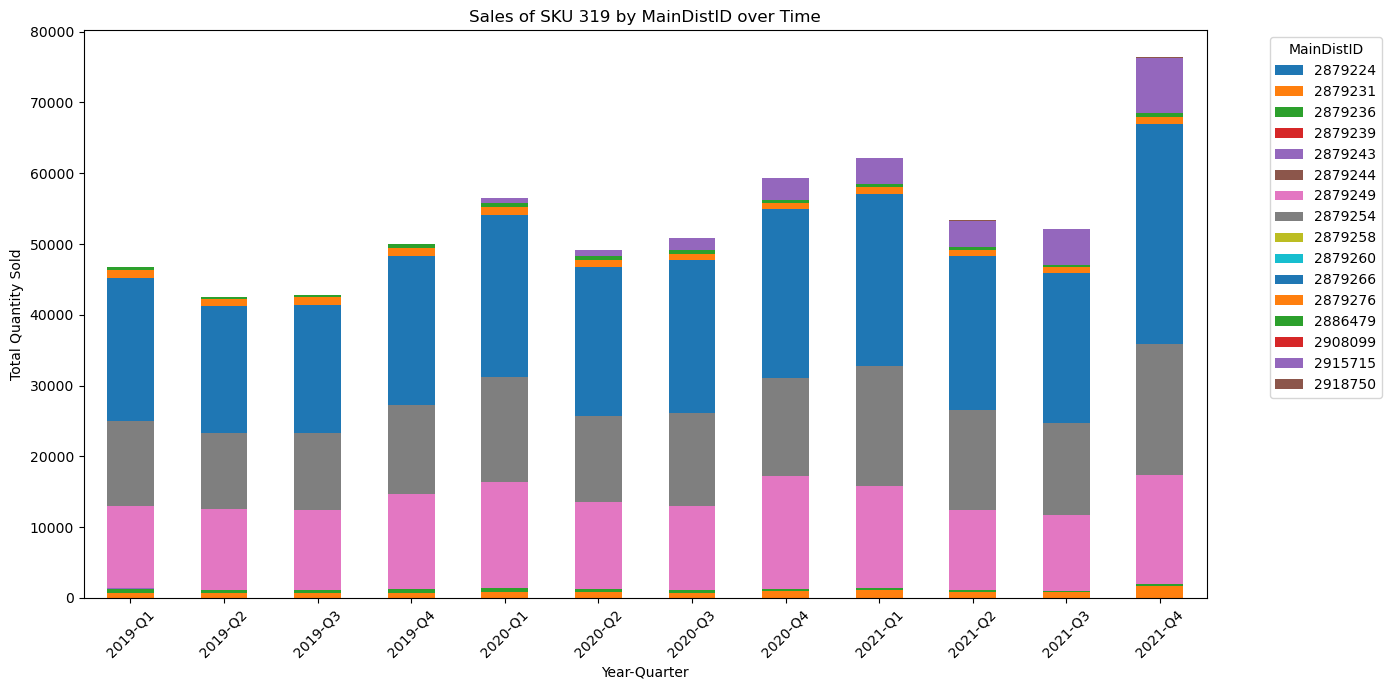

In [78]:
for sku_id in all_sku_ids:
    sku_data = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == sku_id]
    sku_data.set_index(['Year', 'Quarter'], inplace=True)
    plot_sku_main_dist(sku_id)

In [79]:
sku_319 = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == "319"]
sku_319

,Year,Quarter,MainDistID,SkuID,TotalQuantity
0,2019,1,2879231,319,763
1,2019,1,2879236,319,554
2,2019,1,2879243,319,149
3,2019,1,2879244,319,8
4,2019,1,2879249,319,11532
...,...,...,...,...,...
129,2021,4,2879266,319,31130
130,2021,4,2879276,319,984
131,2021,4,2886479,319,461
132,2021,4,2915715,319,7853


### Is there any Trend, Seasonality, Randomness, Slighlty Increasing Trend, or Decreasing Trend in the data?

SKU 319


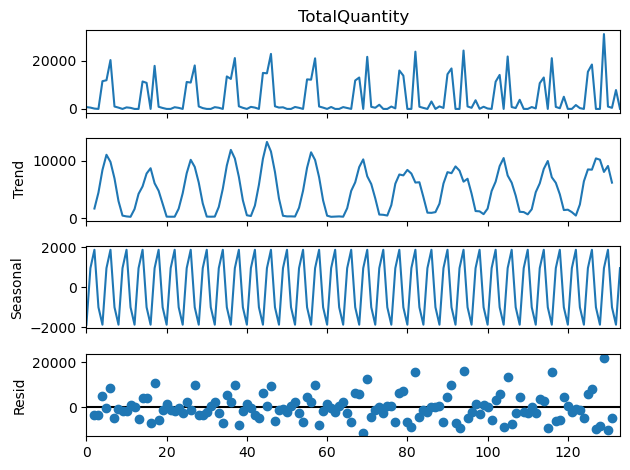

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose

for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == sku_id]
    result = seasonal_decompose(sku_data['TotalQuantity'], model='additive', period=4)
    result.plot()
    plt.show()

In [81]:
## MUHTEMELEN EKSIK VAR BU KISIMDA

# Forecasting

Make forecasts for the choosen SKU's and every MainDistID using the following methods:
- Exponential Smoothing
- Moving Average
- Naive
- Triple Exponential Smoothing

### Evaluation Metrics
- Mean Absolute Percentage Error (MAPE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Bias

## Training and Testing Data
- Training Data: 2019-Q1 to 2020-Q4
- Testing Data: 2021-Q1 to 2021-Q4

```python
train = sku_data['TotalQuantity'][:-4]
test = sku_data['TotalQuantity'][-4:]
```

## Exponential Smoothing

In [82]:
def calculate_metrics(actual, forecasted):
    mape = (np.abs((forecasted - actual) / actual).replace([np.inf, -np.inf], np.nan).dropna()).mean()
    mse = ((forecasted - actual) ** 2).mean()
    rmse = mse ** 0.5
    bias = (forecasted - actual).mean()
    return mape, mse, rmse, bias

In [96]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def NaiveForecast(train_data, forecast_periods=4):
    forecast = train_data[-1:].values[0]
    return np.array([forecast] * forecast_periods)

def MovingAverageForecast(train_data, forecast_periods=4):
    forecast = np.array([train_data.mean()] * forecast_periods)
    return forecast

def ExponentialSmoothingForecast(train_data, forecast_periods=4):
    exp_smoothing = ExponentialSmoothing(train_data.squeeze(), seasonal='add', seasonal_periods=4, trend='add').fit()
    forecast = exp_smoothing.forecast(forecast_periods)
    return forecast

def TripleExponentialSmoothingForecast(train_data, forecast_periods=4):
    triple_exp_smoothing = ExponentialSmoothing(train_data.squeeze(), seasonal='add', seasonal_periods=4, trend='add').fit()
    forecast = triple_exp_smoothing.forecast(forecast_periods)
    return forecast


In [113]:
def plot_forecasts_and_calculate_metrics_quarterly(sku_id):
    df = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == sku_id]
    df['Date'] = df.apply(lambda row: f"{row['Year']}-Q{row['Quarter']}", axis=1)
    df['Date'] = pd.PeriodIndex(df['Date'], freq='Q').to_timestamp()
    df.set_index('Date', inplace=True)
    df = df.drop(columns=['Year', 'Quarter'])
    
    # Ensure the series is of numeric type
    df = df.astype(float)
    
    metrics = {}
    
    for main_dist_id in df['MainDistID'].unique():
        main_dist_data = df[df['MainDistID'] == main_dist_id]['TotalQuantity']
        train = main_dist_data[:-4]
        test = main_dist_data[-4:]
        
        # Check if the data is not enough
        if len(test) < 4:
            print(f"Not enough data for testing forecasting for MainDistID {main_dist_id}. Skipping.")
            continue
            
        if len(train) < 8:
            print(f"Not enough data for training forecasting for MainDistID {main_dist_id}. Skipping.")
            continue
        
        # Forecasting methods
        naive_forecast = NaiveForecast(train, forecast_periods=4)
        moving_avg_forecast = MovingAverageForecast(train, forecast_periods=4)
        ses_forecast = ExponentialSmoothingForecast(train, forecast_periods=4)
        tes_forecast = TripleExponentialSmoothingForecast(train, forecast_periods=4)
        
        # Calculate metrics
        naive_mape, naive_mse, naive_rmse, naive_bias = calculate_metrics(test, naive_forecast)
        moving_avg_mape, moving_avg_mse, moving_avg_rmse, moving_avg_bias = calculate_metrics(test, moving_avg_forecast)
        ses_mape, ses_mse, ses_rmse, ses_bias = calculate_metrics(test, ses_forecast)
        tes_mape, tes_mse, tes_rmse, tes_bias = calculate_metrics(test, tes_forecast)
        
        metrics[main_dist_id] = {
            'Naive': {'MAPE': naive_mape, 'MSE': naive_mse, 'RMSE': naive_rmse, 'Bias': naive_bias},
            'Moving Average': {'MAPE': moving_avg_mape, 'MSE': moving_avg_mse, 'RMSE': moving_avg_rmse, 'Bias': moving_avg_bias},
            'Exponential Smoothing': {'MAPE': ses_mape, 'MSE': ses_mse, 'RMSE': ses_rmse, 'Bias': ses_bias},
            'Triple Exponential Smoothing': {'MAPE': tes_mape, 'MSE': tes_mse, 'RMSE': tes_rmse, 'Bias': tes_bias}
        }
        
        # Plotting
        plt.figure(figsize=(14, 7))
        plt.plot(train.index, train, label='Original (Train)')
        plt.plot(test.index, test, label='Original (Test)', color='gray')
        plt.plot(test.index, naive_forecast, label='Naive Forecast', linestyle='--')
        plt.plot(test.index, moving_avg_forecast, label='Moving Average Forecast', linestyle='--')
        plt.plot(test.index, ses_forecast, label='Exponential Smoothing Forecast', linestyle='--')
        plt.plot(test.index, tes_forecast, label='Triple Exponential Smoothing Forecast', linestyle='--')
        
        plt.title(f'Sales Forecast for SKU {sku_id} - MainDistID {main_dist_id}')
        plt.xlabel('Year-Quarter')
        plt.ylabel('Total Quantity Sold')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    metrics_df = pd.DataFrame.from_dict({(i,j): metrics[i][j] 
                             for i in metrics.keys() 
                             for j in metrics[i].keys()},
                            orient='index')
    metrics_df.index = metrics_df.index.rename(['MainDistID', 'Method'])
    metrics_df.index = metrics_df.index.set_levels(metrics_df.index.levels[0].astype(int), level=0)
        
    return metrics_df

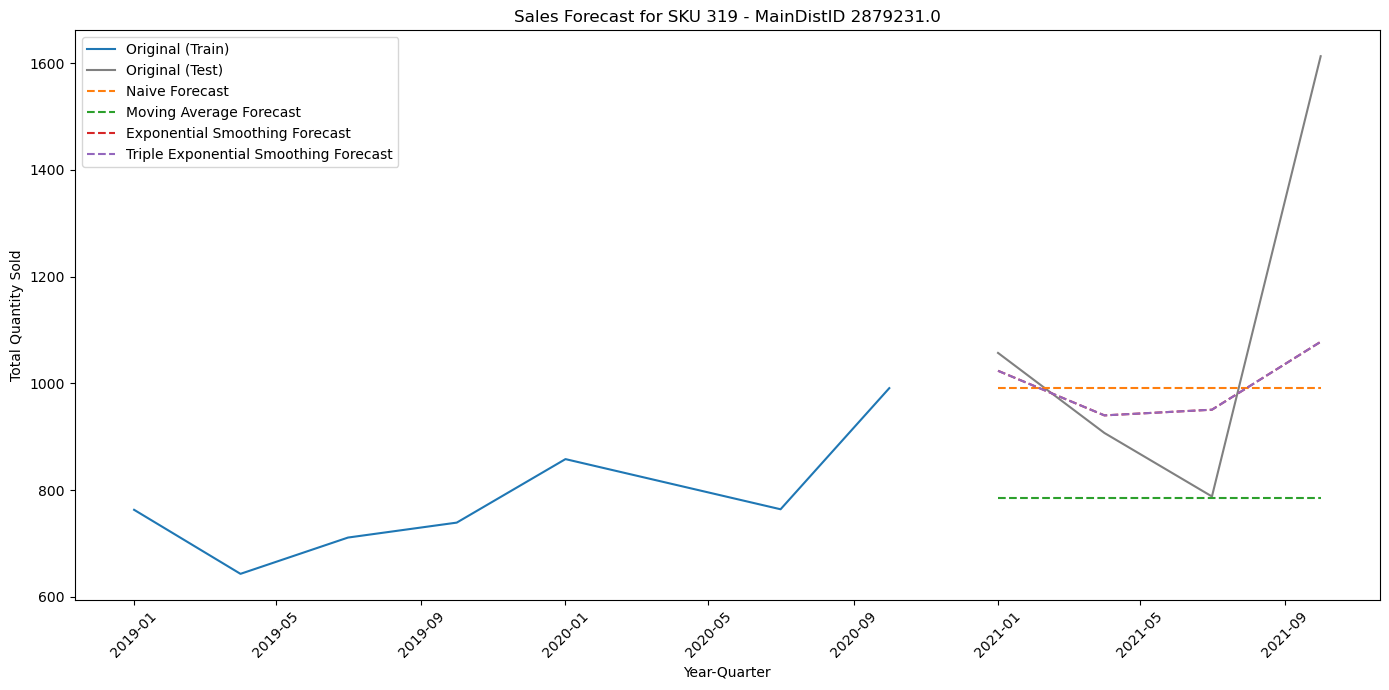

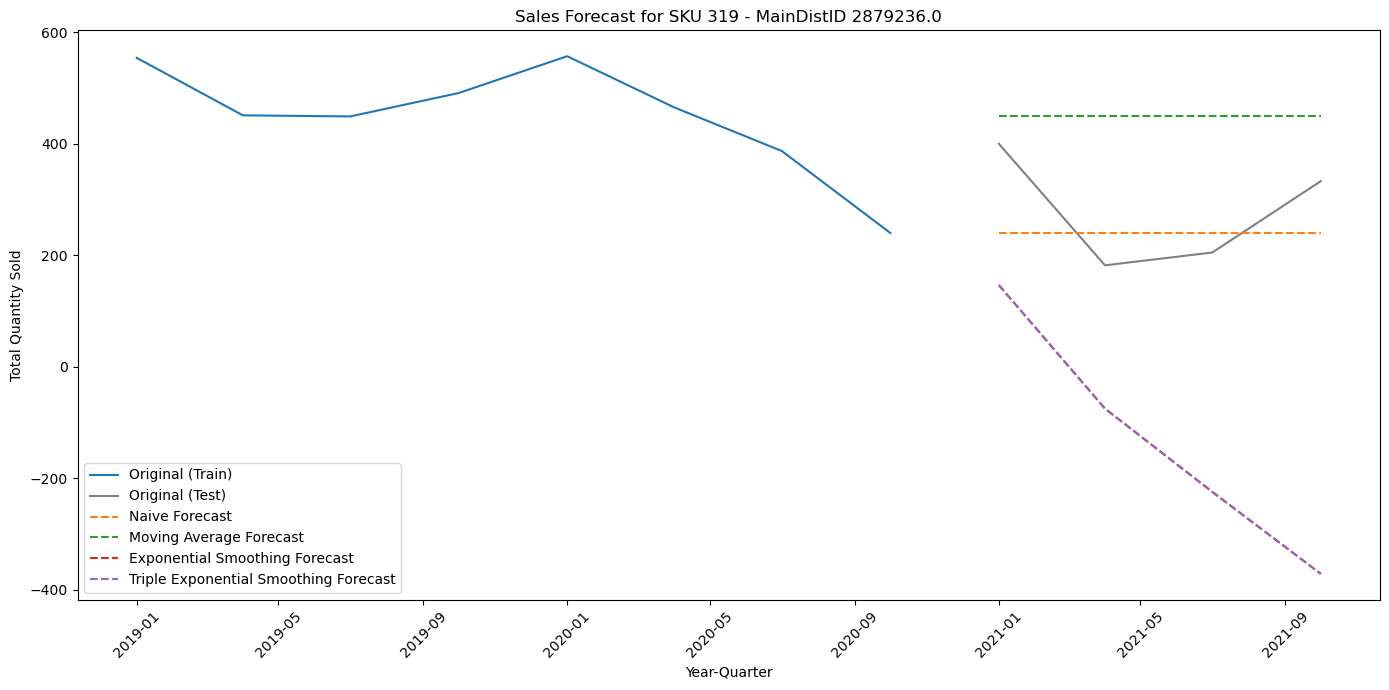

Not enough data for testing forecasting for MainDistID 2879243.0. Skipping.
Not enough data for training forecasting for MainDistID 2879244.0. Skipping.


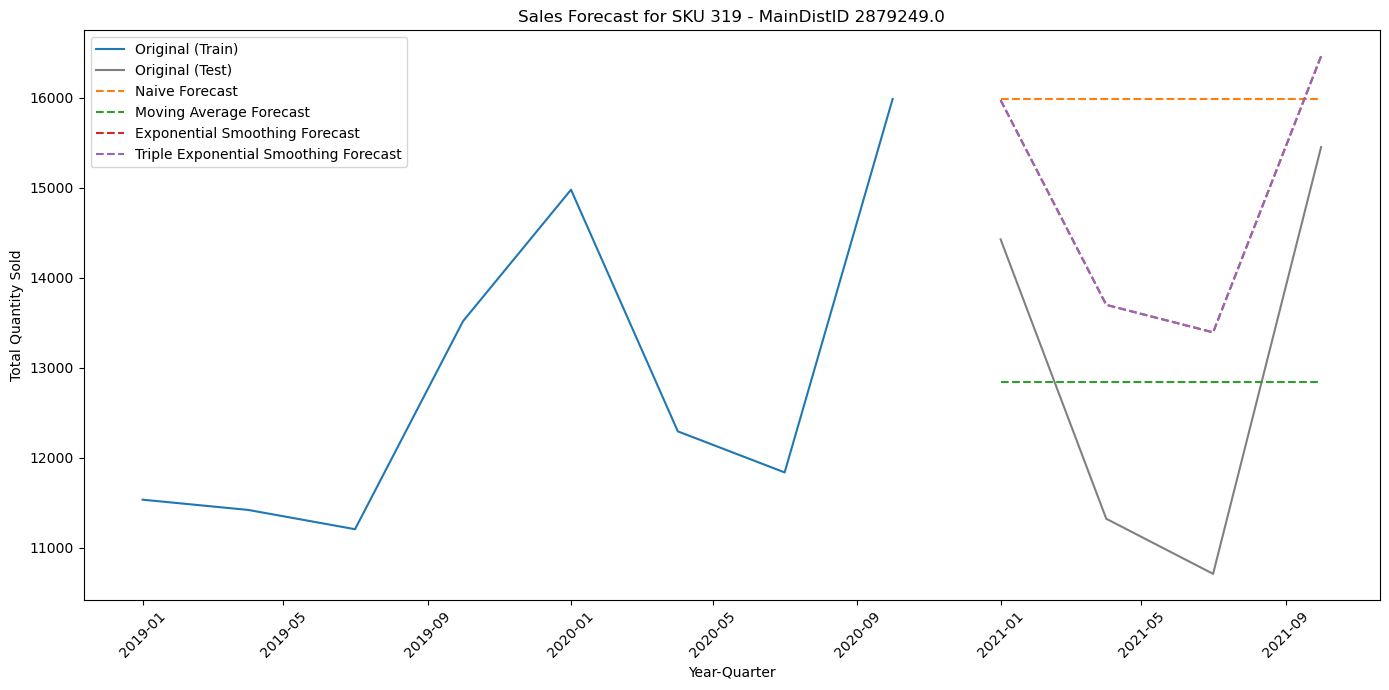

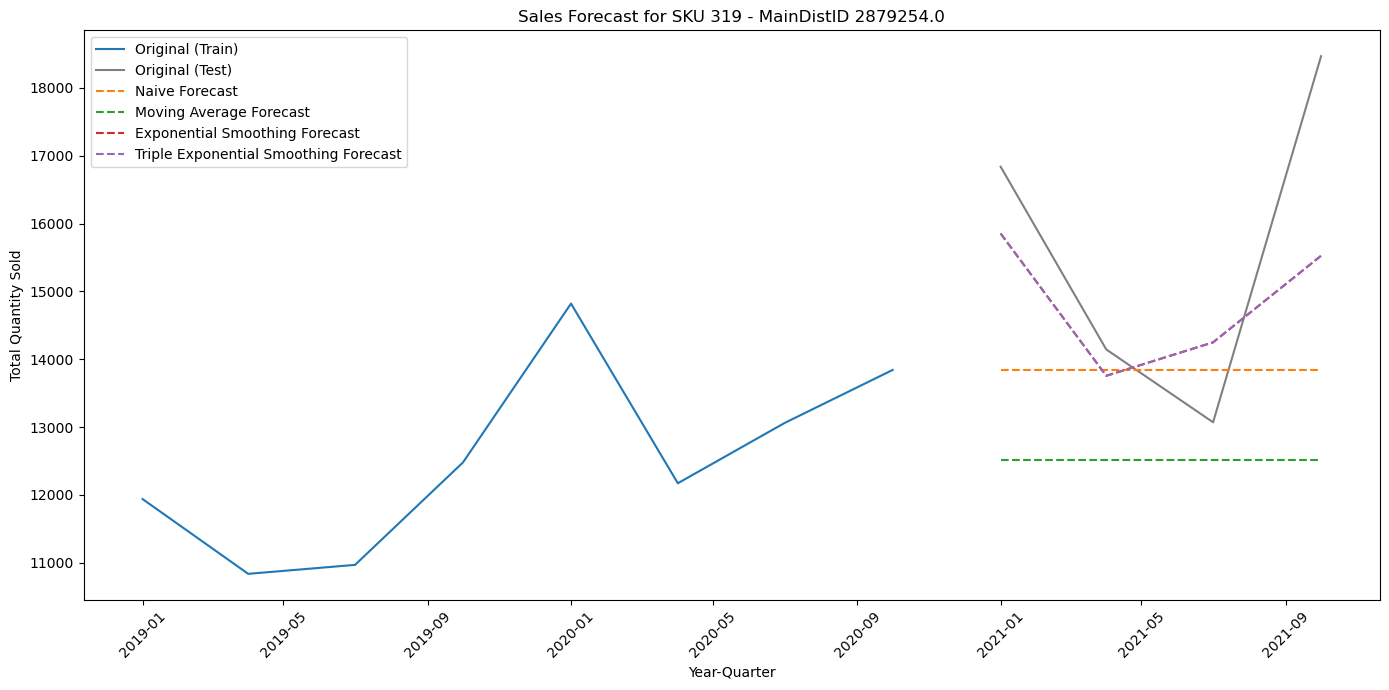

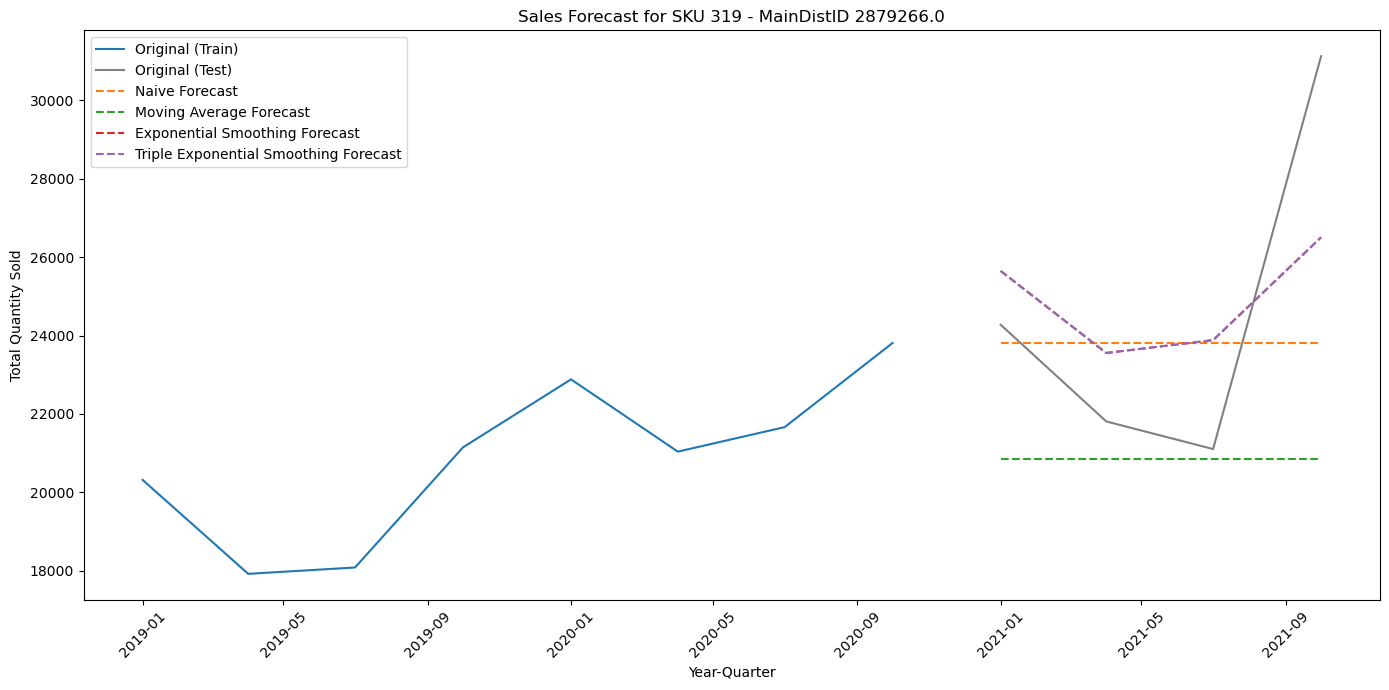

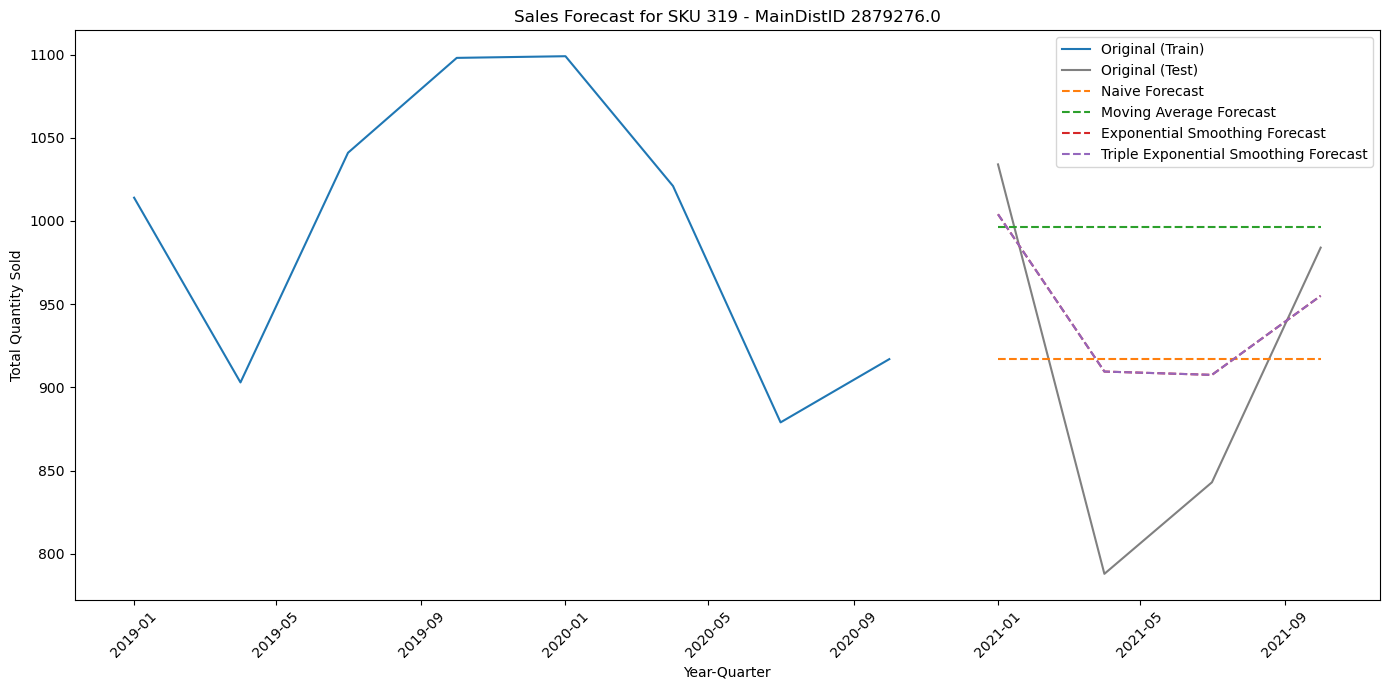

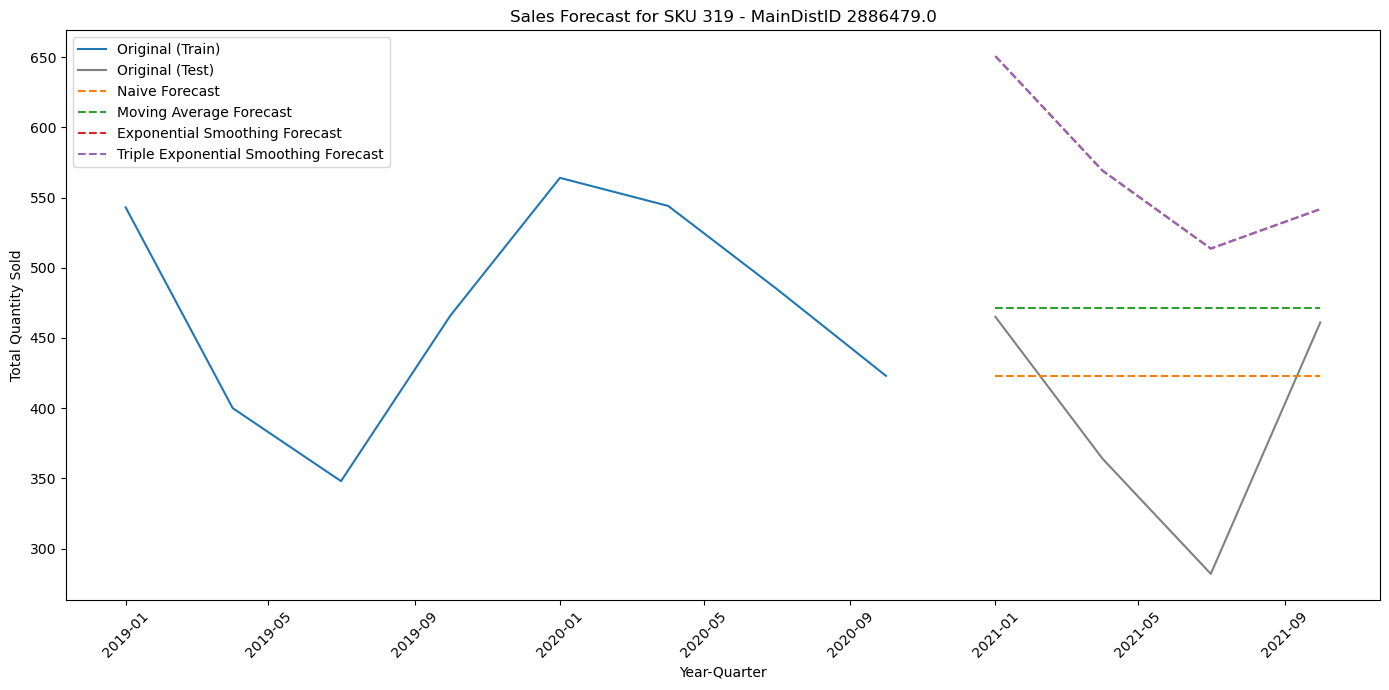

Not enough data for training forecasting for MainDistID 2908099.0. Skipping.
Not enough data for testing forecasting for MainDistID 2879239.0. Skipping.
Not enough data for training forecasting for MainDistID 2879260.0. Skipping.
Not enough data for training forecasting for MainDistID 2879224.0. Skipping.
Not enough data for training forecasting for MainDistID 2915715.0. Skipping.
Not enough data for training forecasting for MainDistID 2918750.0. Skipping.
Not enough data for training forecasting for MainDistID 2879258.0. Skipping.


In [115]:
metrics_df_quarterly = plot_forecasts_and_calculate_metrics_quarterly('319')

In [116]:
metrics_df_quarterly

MAPE           MSE         RMSE  \
MainDistID Method                                                              
2879231    Naive                         0.199571  1.098762e+05   331.475866   
           Moving Average                0.227244  1.936152e+05   440.017329   
           Exponential Smoothing         0.151515  7.874627e+04   280.617664   
           Triple Exponential Smoothing  0.151515  7.874627e+04   280.617664   
2879236    Naive                         0.292173  9.709500e+03    98.536795   
           Moving Average                0.783024  3.675506e+04   191.716099   
           Exponential Smoothing         1.563408  2.025937e+05   450.104086   
           Triple Exponential Smoothing  1.563408  2.025937e+05   450.104086   
2879249    Naive                         0.261878  1.307722e+07  3616.244495   
           Moving Average                0.153071  4.041776e+06  2010.416861   
           Exponential Smoothing         0.158275  4.064582e+06  2016.080954   
           Triple Exponential Smoothing  0.158275  4.064582e+06  2016.080954   
2879254    Naive                         0.127161  7.760759e+06  2785.813930   
           Moving Average                0.184168  1.426638e+07  3777.085748   
           Exponential Smoothing         0.083824  2.789254e+06  1670.106115   
           Triple Exponential Smoothing  0.083824  2.789254e+06  1670.106115   
2879266    Naive                         0.118600  1.627600e+07  4034.352302   
           Moving Average                0.131516  2.954023e+07  5435.092111   
           Exponential Smoothing         0.104200  8.505346e+06  2916.392709   
           Triple Exponential Smoothing  0.104200  8.505346e+06  2916.392709   
2879276    Naive                         0.108182  1.007375e+04   100.368073   
           Moving Average                0.123913  1.714925e+04   130.955145   
           Exponential Smoothing         0.072301  5.168477e+03    71.892122   
           Triple Exponential Smoothing  0.072301  5.168477e+03    71.892122   
2886479    Naive                         0.208710  6.642500e+03    81.501534   
           Moving Average                0.251349  1.192439e+04   109.198858   
           Exponential Smoothing         0.489801  3.417495e+04   184.864687   
           Triple Exponential Smoothing  0.489801  3.417495e+04   184.864687   

                                                Bias  
MainDistID Method                                     
2879231    Naive                         -100.250000  
           Moving Average                -306.250000  
           Exponential Smoothing          -93.271409  
           Triple Exponential Smoothing   -93.271409  
2879236    Naive                          -40.000000  
           Moving Average                 169.250000  
           Exponential Smoothing         -410.931821  
           Triple Exponential Smoothing  -410.931821  
2879249    Naive                         3008.750000  
           Moving Average                -130.875000  
           Exponential Smoothing         1904.042603  
           Triple Exponential Smoothing  1904.042603  
2879254    Naive                        -1787.750000  
           Moving Average               -3114.750000  
           Exponential Smoothing         -784.055170  
           Triple Exponential Smoothing  -784.055170  
2879266    Naive                         -767.500000  
           Moving Average               -3722.000000  
           Exponential Smoothing          319.320013  
           Triple Exponential Smoothing   319.320013  
2879276    Naive                            4.750000  
           Moving Average                  84.250000  
           Exponential Smoothing           31.791544  
           Triple Exponential Smoothing    31.791544  
2886479    Naive                           30.000000  
           Moving Average                  78.625000  
           Exponential Smoothing          175.773693  
           Triple Exponential Smoothing   175.773

In [117]:
metrics_df_quarterly.loc[(2879231, 'Moving Average')]

MAPE         0.227244
MSE     193615.250000
RMSE       440.017329
Bias      -306.250000
Name: (2879231, Moving Average), dtype: float64

# Monthly Sales Analysis


In [102]:
main_dist_data_monthly = data.copy()
main_dist_data_monthly['Year'] = main_dist_data_monthly['Date'].dt.year
main_dist_data_monthly['Month'] = main_dist_data_monthly['Date'].dt.month

main_dist_data_monthly = main_dist_data_monthly.groupby(['Year', 'Month', 'MainDistID', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
main_dist_data_monthly

,Year,Month,MainDistID,SkuID,TotalQuantity
0,2019,1,2879231,319,332
1,2019,1,2879236,319,219
2,2019,1,2879243,319,128
3,2019,1,2879244,319,3
4,2019,1,2879249,319,3988
...,...,...,...,...,...
338,2021,12,2879266,319,10467
339,2021,12,2879276,319,318
340,2021,12,2886479,319,196
341,2021,12,2915715,319,3117


In [103]:
def plot_sku_main_dist_monthly(sku_id):
    sku_data = main_dist_data_monthly[main_dist_data_monthly['SkuID'] == sku_id]
    sku_data['YearMonth'] = sku_data['Year'].astype(str) + '-' + sku_data['Month'].astype(str).str.zfill(2)
    pivot_table = sku_data.pivot(index='YearMonth', columns='MainDistID', values='TotalQuantity')
    pivot_table.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.title(f'Sales of SKU {sku_id} by MainDistID over Time')
    plt.xlabel('Year-Month')
    plt.ylabel('Total Quantity Sold')
    plt.legend(title='MainDistID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

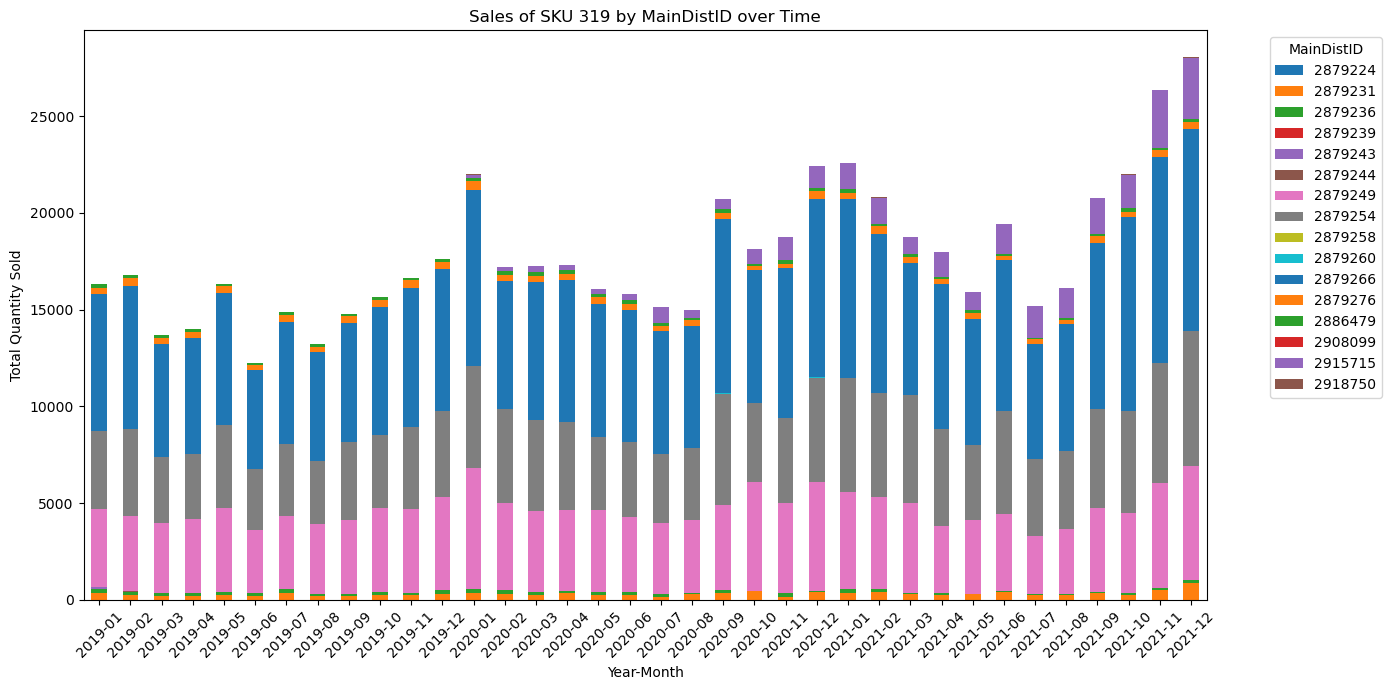

In [104]:
for sku_id in all_sku_ids:
    sku_data = main_dist_data_monthly[main_dist_data_monthly['SkuID'] == sku_id]
    sku_data.set_index(['Year', 'Month'], inplace=True)
    plot_sku_main_dist_monthly(sku_id)

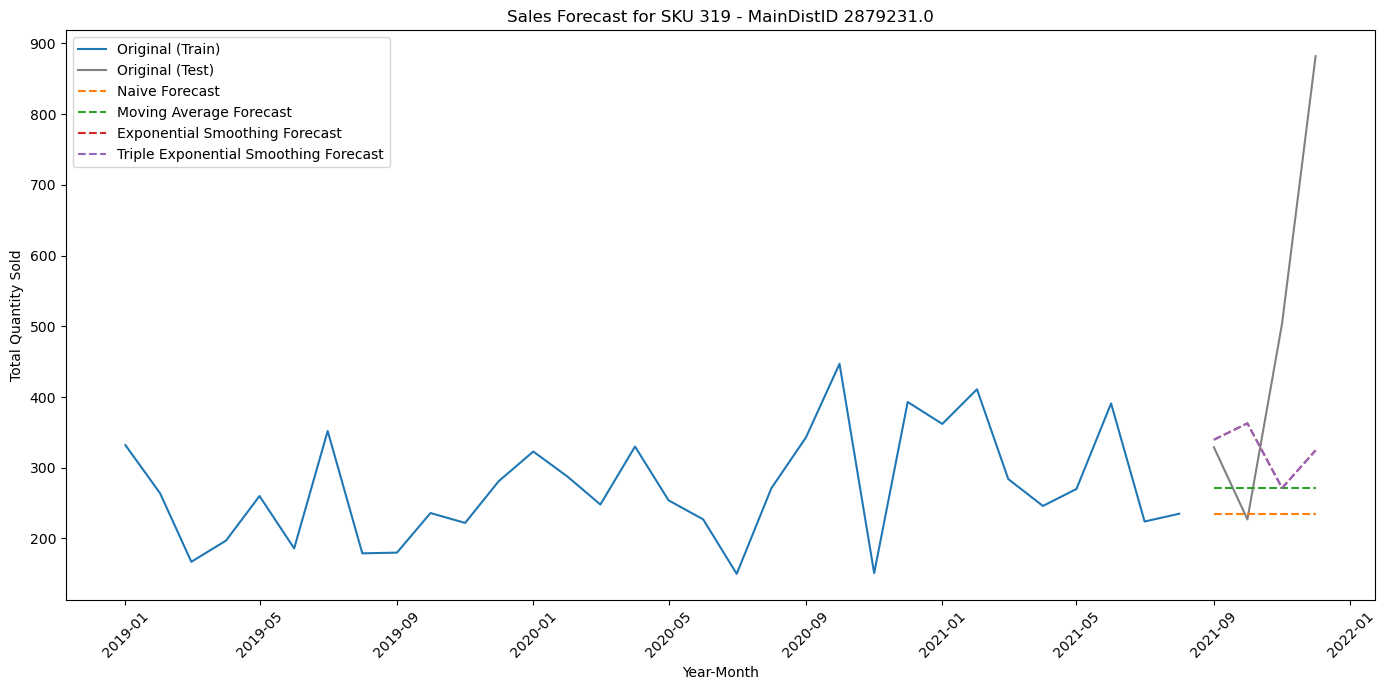

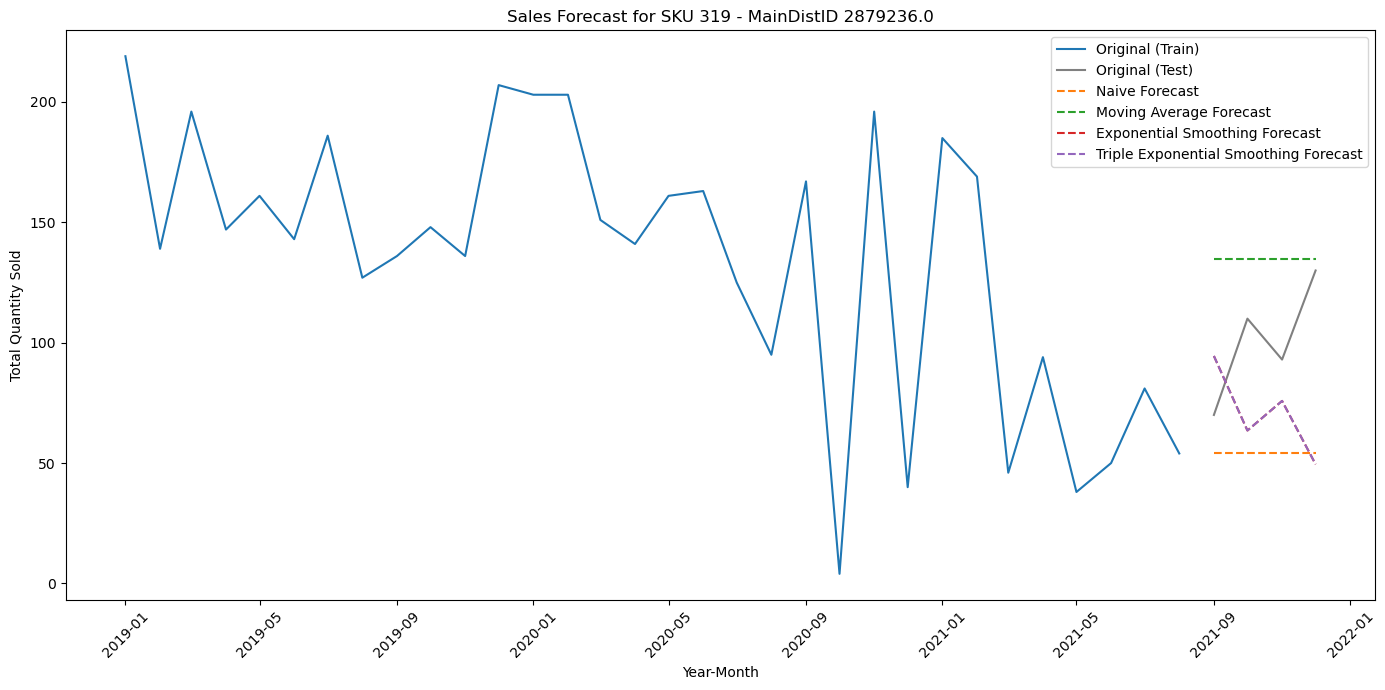

Not enough data for testing forecasting for MainDistID 2879243.0. Skipping.


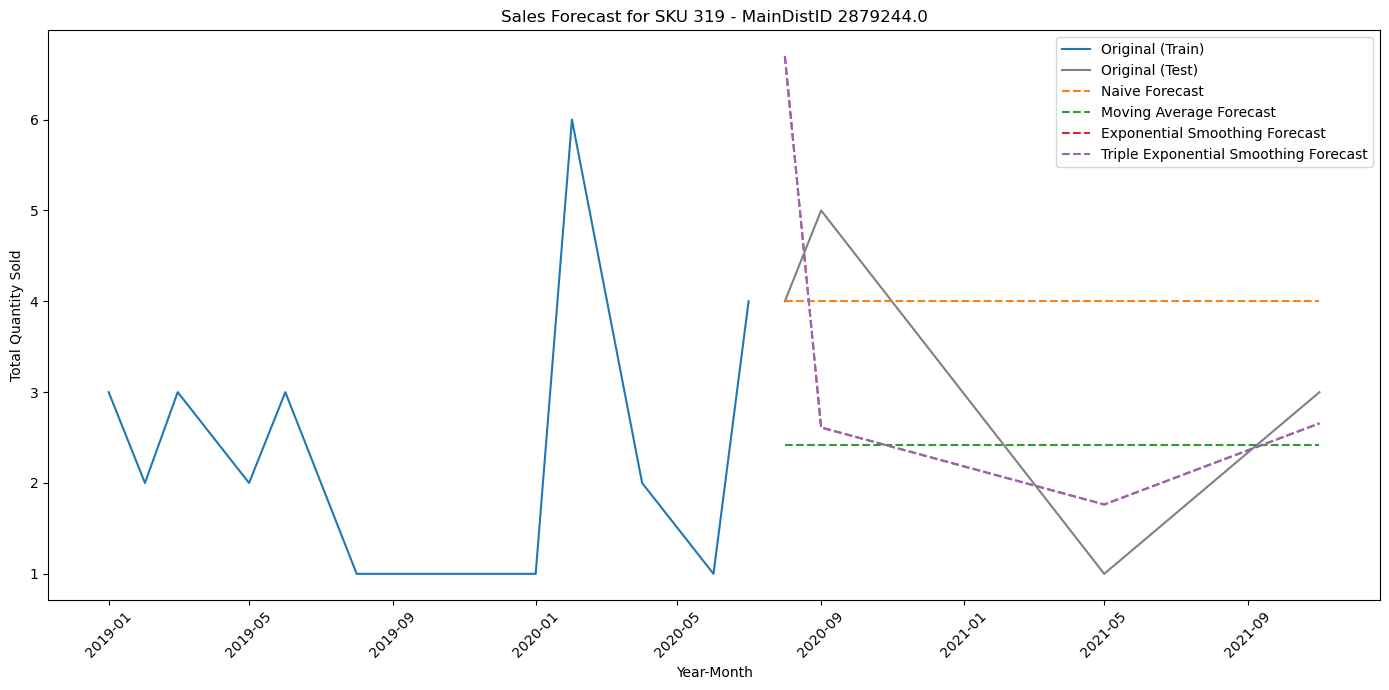

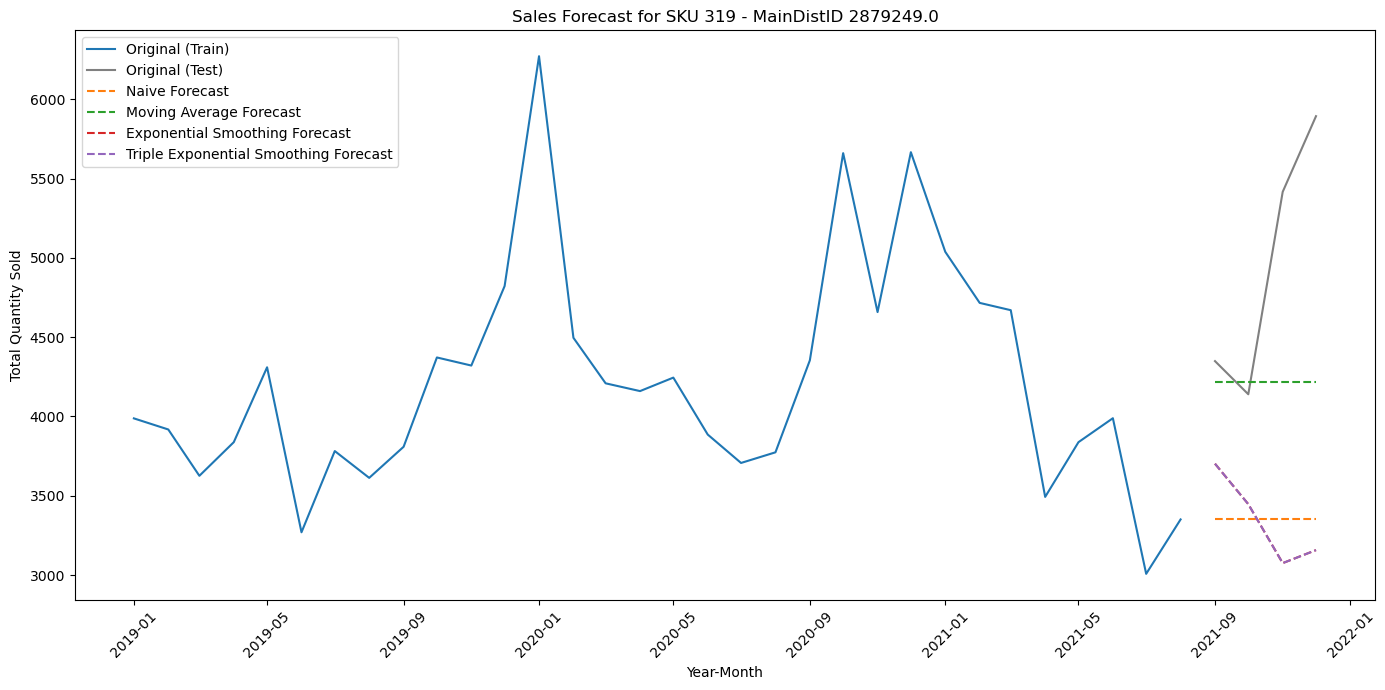

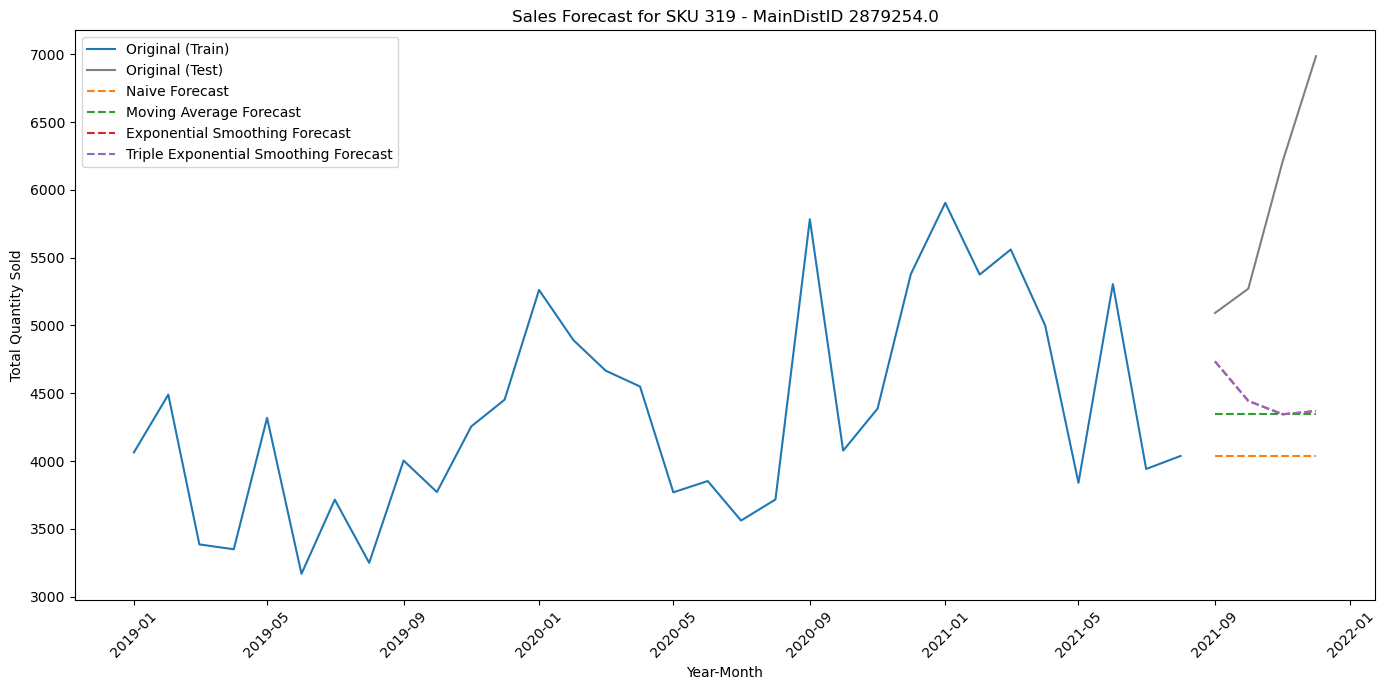

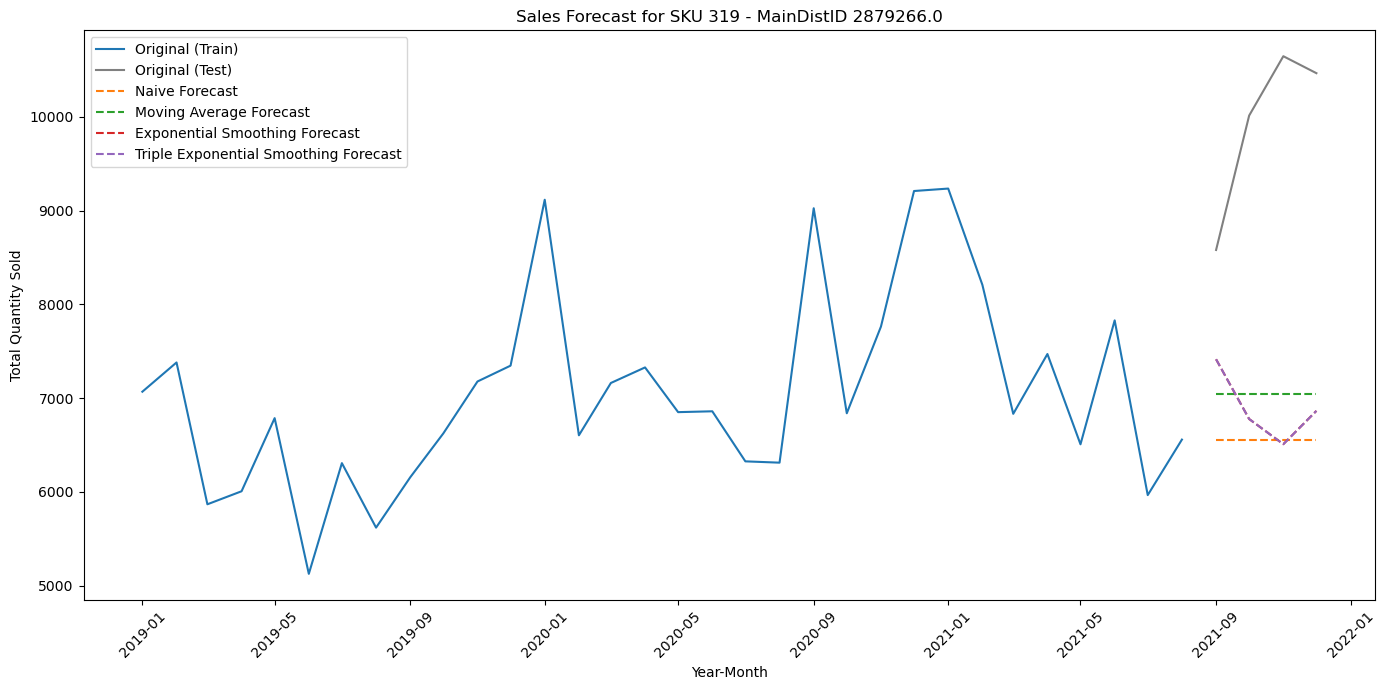

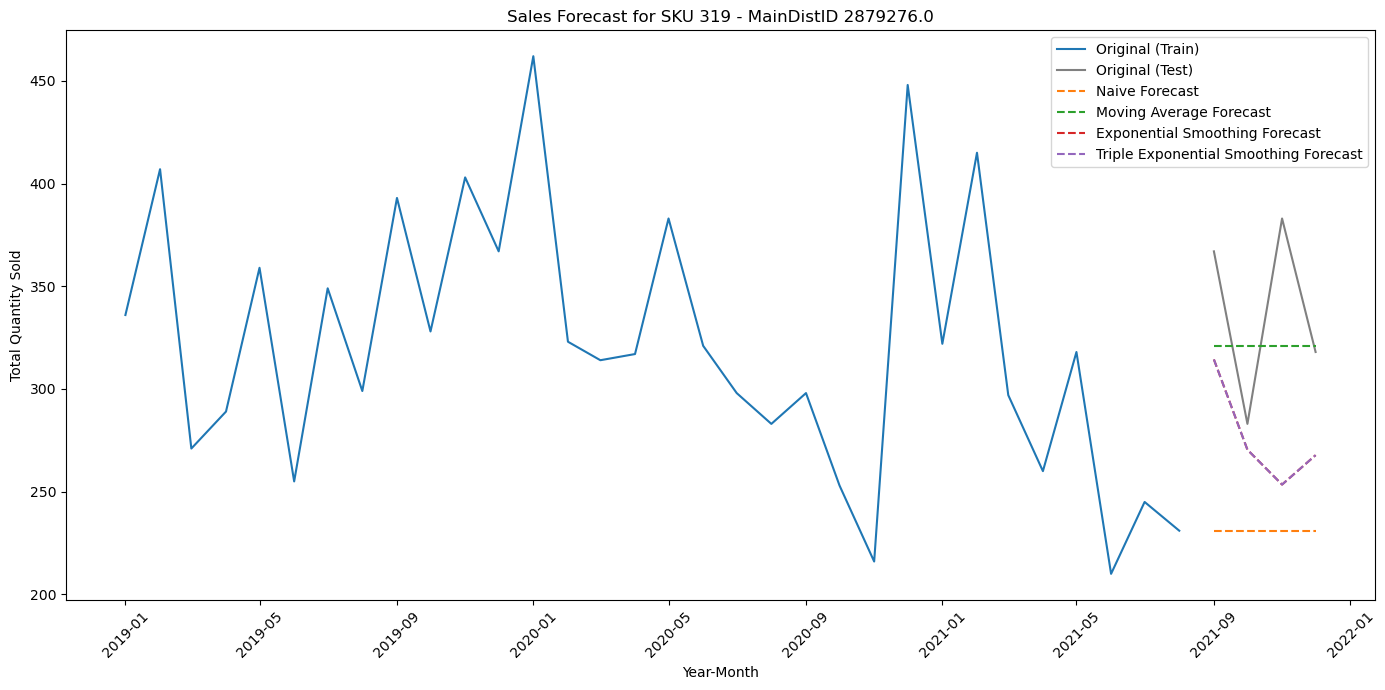

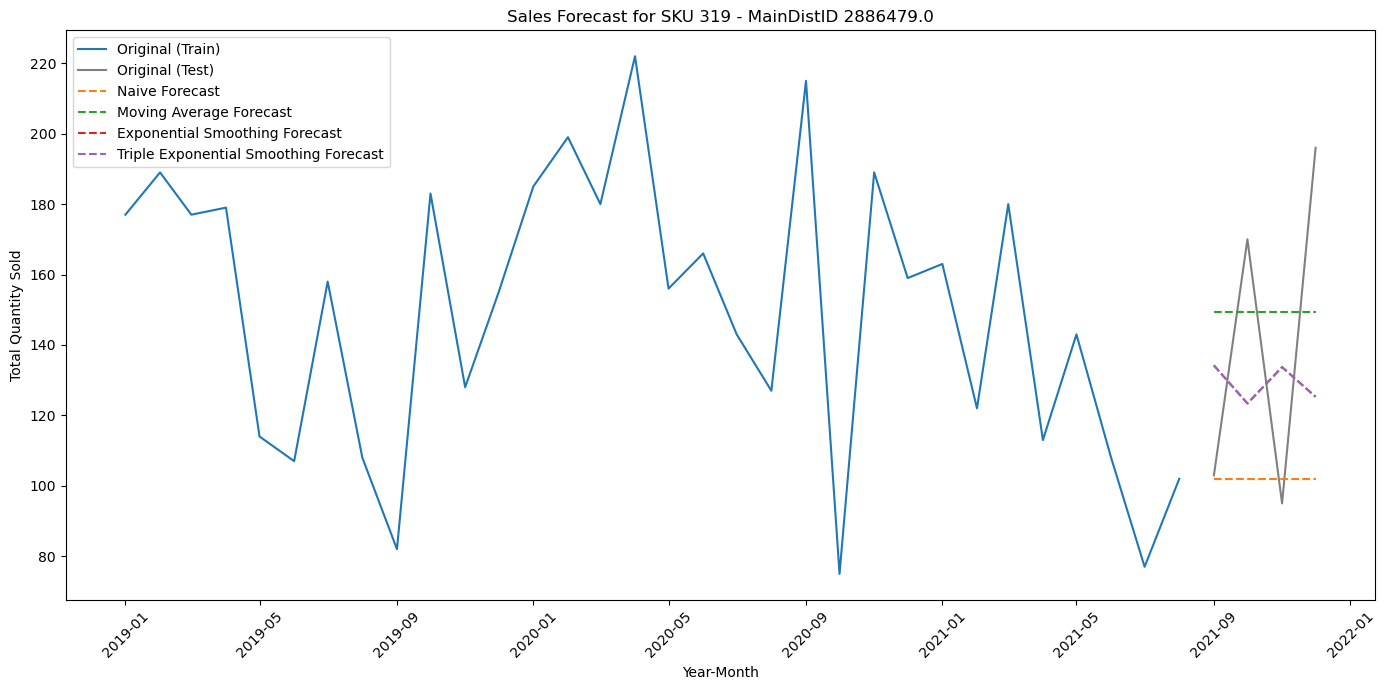

Not enough data for training forecasting for MainDistID 2908099.0. Skipping.
Not enough data for testing forecasting for MainDistID 2879239.0. Skipping.
Not enough data for training forecasting for MainDistID 2879260.0. Skipping.


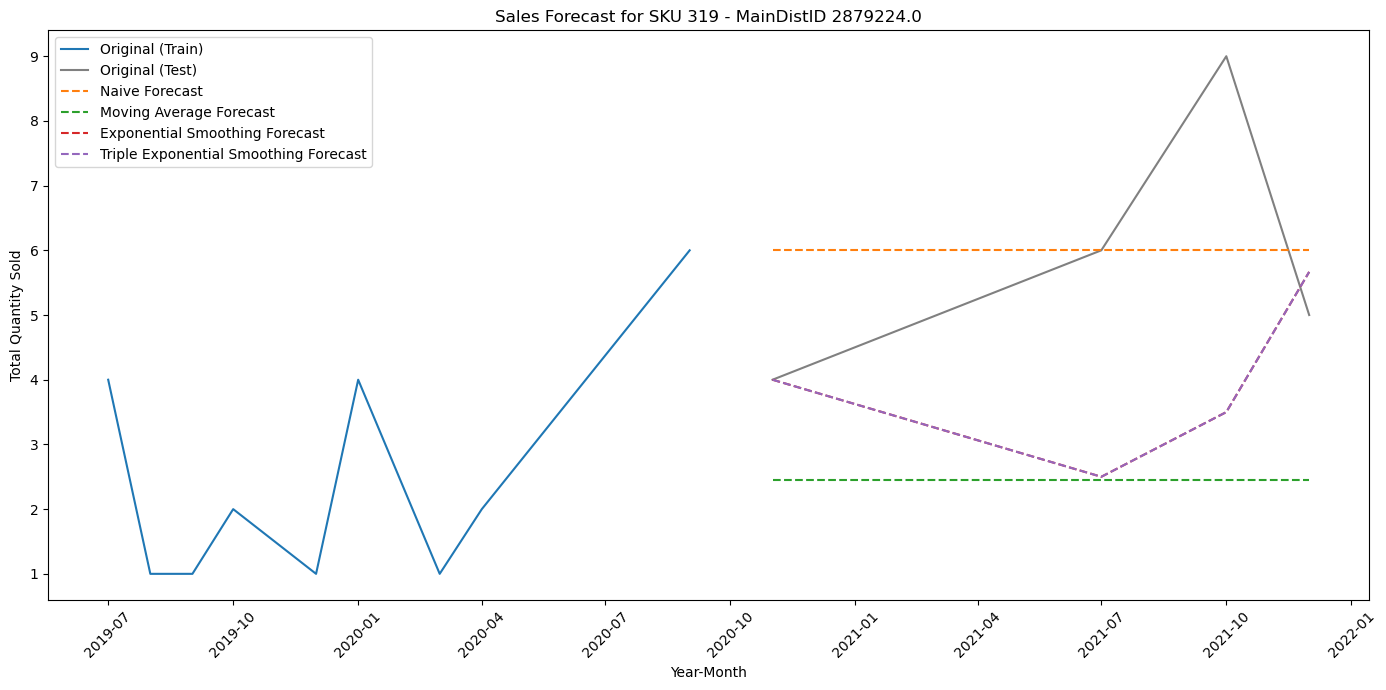

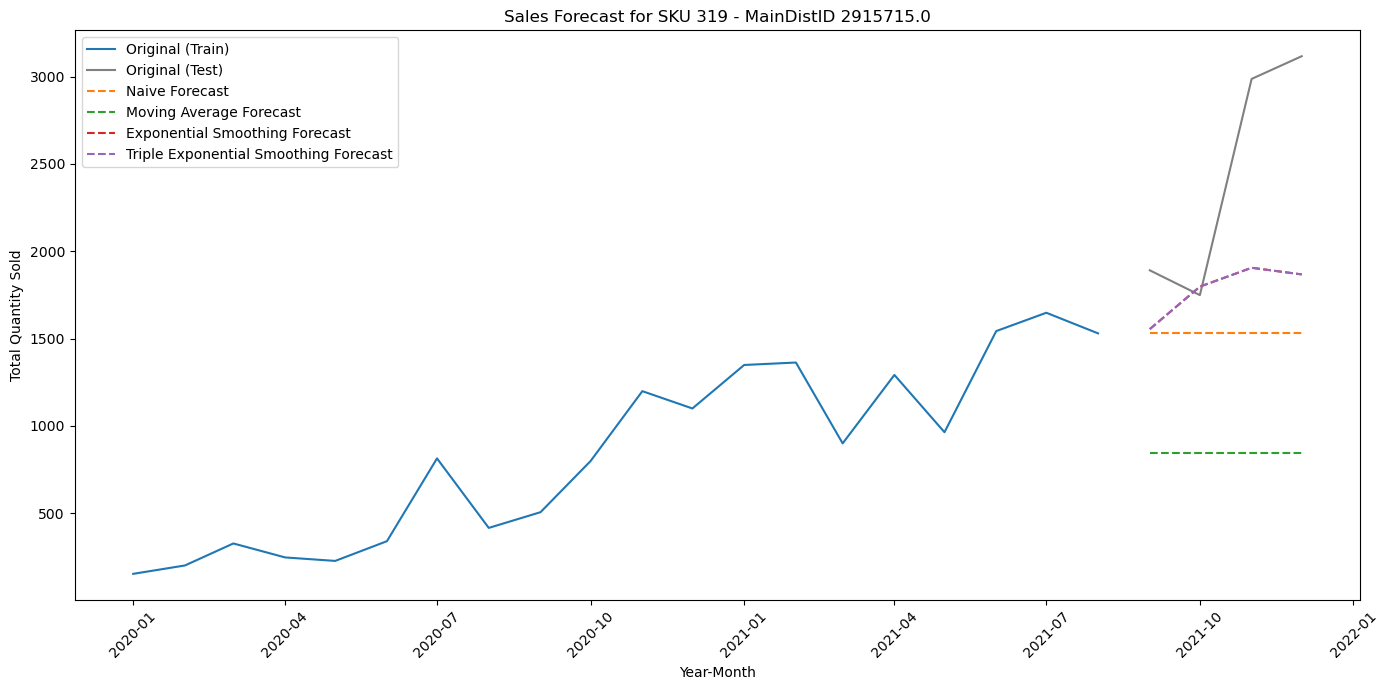

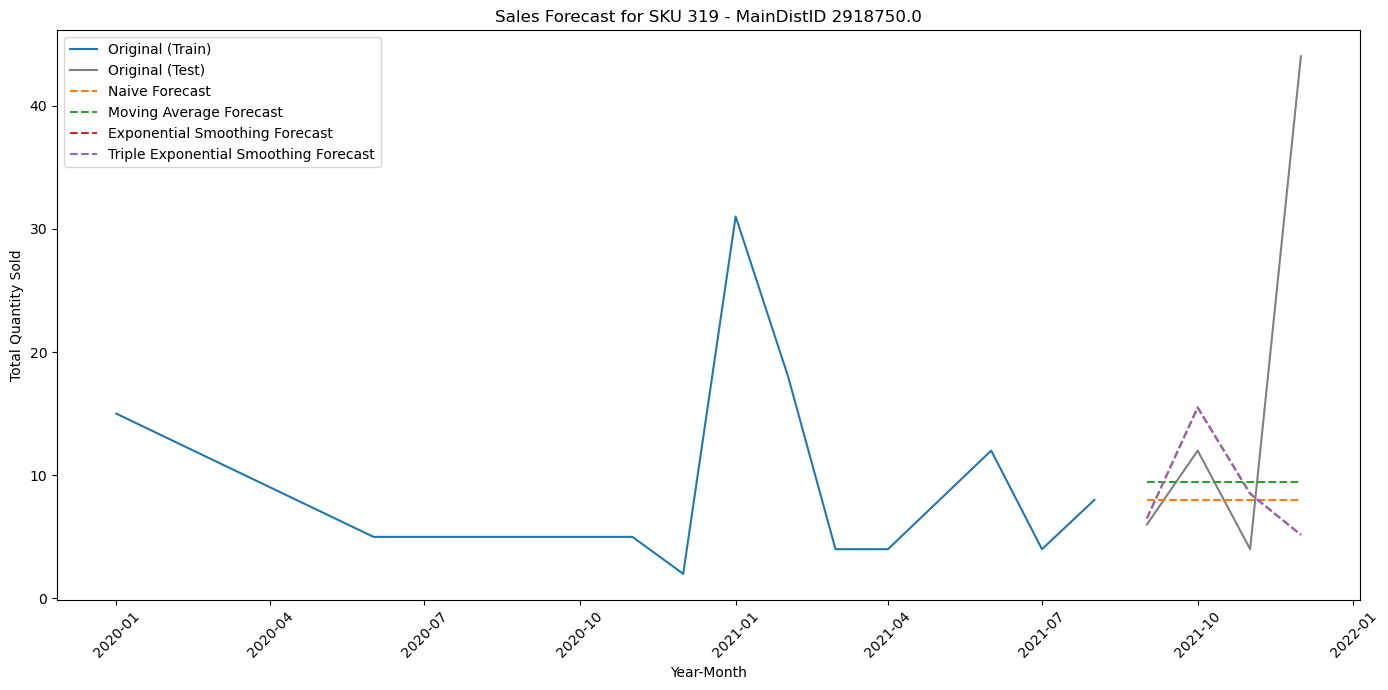

Not enough data for training forecasting for MainDistID 2879258.0. Skipping.


In [107]:

def plot_forecasts_and_calculate_metrics_monthly(sku_id):
    df = main_dist_data_monthly[main_dist_data_monthly['SkuID'] == sku_id]
    df['Date'] = df.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1)
    df['Date'] = pd.PeriodIndex(df['Date'], freq='M').to_timestamp()
    df.set_index('Date', inplace=True)
    df = df.drop(columns=['Year', 'Month'])
    
    # Ensure the series is of numeric type
    df = df.astype(float)
    
    metrics = {}
    
    for main_dist_id in df['MainDistID'].unique():
        main_dist_data = df[df['MainDistID'] == main_dist_id]['TotalQuantity']
        train = main_dist_data[:-4]
        test = main_dist_data[-4:]
        
        # Check if the data is not enough
        if len(test) < 4:
            print(f"Not enough data for testing forecasting for MainDistID {main_dist_id}. Skipping.")
            continue
            
        if len(train) < 8:
            print(f"Not enough data for training forecasting for MainDistID {main_dist_id}. Skipping.")
            continue
        
        # Forecasting methods
        naive_forecast = NaiveForecast(train, forecast_periods=4)
        moving_avg_forecast = MovingAverageForecast(train, forecast_periods=4)
        ses_forecast = ExponentialSmoothingForecast(train, forecast_periods=4)
        tes_forecast = TripleExponentialSmoothingForecast(train, forecast_periods=4)
        
        # Calculate metrics
        naive_mape, naive_mse, naive_rmse, naive_bias = calculate_metrics(test, naive_forecast)
        moving_avg_mape, moving_avg_mse, moving_avg_rmse, moving_avg_bias = calculate_metrics(test, moving_avg_forecast)
        ses_mape, ses_mse, ses_rmse, ses_bias = calculate_metrics(test, ses_forecast)
        tes_mape, tes_mse, tes_rmse, tes_bias = calculate_metrics(test, tes_forecast)
        
        metrics[main_dist_id] = {
            'Naive': {'MAPE': naive_mape, 'MSE': naive_mse, 'RMSE': naive_rmse, 'Bias': naive_bias},
            'Moving Average': {'MAPE': moving_avg_mape, 'MSE ': moving_avg_mse, 'RMSE': moving_avg_rmse, 'Bias': moving_avg_bias},
            'Exponential Smoothing': {'MAPE': ses_mape, 'MSE': ses_mse, 'RMSE': ses_rmse, 'Bias': ses_bias},
            'Triple Exponential Smoothing': {'MAPE': tes_mape, 'MSE': tes_mse, 'RMSE': tes_rmse, 'Bias': tes_bias}
        }
        
        # Plotting
        plt.figure(figsize=(14, 7))
        plt.plot(train.index, train, label='Original (Train)')
        plt.plot(test.index, test, label='Original (Test)', color='gray')
        plt.plot(test.index, naive_forecast, label='Naive Forecast', linestyle='--')
        plt.plot(test.index, moving_avg_forecast, label='Moving Average Forecast', linestyle='--')
        plt.plot(test.index, ses_forecast, label='Exponential Smoothing Forecast', linestyle='--')
        plt.plot(test.index, tes_forecast, label='Triple Exponential Smoothing Forecast', linestyle='--')
        
        plt.title(f'Sales Forecast for SKU {sku_id} - MainDistID {main_dist_id}')
        plt.xlabel('Year-Month')
        plt.ylabel('Total Quantity Sold')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    metrics_df = pd.DataFrame.from_dict({(i,j): metrics[i][j]
                                for i in metrics.keys()
                                for j in metrics[i].keys()},
                                orient='index')
    metrics_df.index = metrics_df.index.rename(['MainDistID', 'Method'])
    metrics_df.index = metrics_df.index.set_levels(metrics_df.index.levels[0].astype(int), level=0)
    
    return metrics_df

metrics_df_monthly = plot_forecasts_and_calculate_metrics_monthly('319')

In [108]:
metrics_df_monthly

MAPE           MSE         RMSE  \
MainDistID Method                                                              
2879231    Naive                         0.397062  1.249675e+05   353.507426   
           Moving Average                0.380868           NaN   328.348663   
           Exponential Smoothing         0.431051  9.583100e+04   309.565819   
           Triple Exponential Smoothing  0.431051  9.583100e+04   309.565819   
2879236    Naive                         0.435408  2.672250e+03    51.693810   
           Moving Average                0.408539           NaN    40.503870   
           Exponential Smoothing         0.394043  2.383568e+03    48.821795   
           Triple Exponential Smoothing  0.394043  2.383568e+03    48.821795   
2879244    Naive                         0.883333  2.750000e+00     1.658312   
           Moving Average                0.630903           NaN     1.697629   
           Exponential Smoothing              NaN           NaN          NaN   
           Triple Exponential Smoothing       NaN           NaN          NaN   
2879249    Naive                         0.308174  3.086128e+06  1756.738028   
           Moving Average                0.138915           NaN  1035.097537   
           Exponential Smoothing         0.303089  3.464623e+06  1861.349652   
           Triple Exponential Smoothing  0.303089  3.464623e+06  1861.349652   
2879254    Naive                         0.303170  4.009486e+06  2002.370033   
           Moving Average                0.249911           NaN  1720.971369   
           Exponential Smoothing         0.225432  2.782984e+06  1668.227835   
           Triple Exponential Smoothing  0.225432  2.782984e+06  1668.227835   
2879266    Naive                         0.334626  1.201294e+07  3465.968804   
           Moving Average                0.285092           NaN  2993.484096   
           Exponential Smoothing         0.297995  1.048658e+07  3238.298433   
           Triple Exponential Smoothing  0.297995  1.048658e+07  3238.298433   
2879276    Naive                         0.306192  1.296825e+04   113.878224   
           Moving Average                0.107712           NaN    43.073747   
           Exponential Smoothing         0.171007  5.557834e+03    74.550879   
           Triple Exponential Smoothing  0.171007  5.557834e+03    74.550879   
2886479    Naive                         0.240746  3.377500e+03    58.116263   
           Moving Average                0.345527           NaN    43.899488   
           Exponential Smoothing         0.336362  2.411619e+03    49.108237   
           Triple Exponential Smoothing  0.336362  2.411619e+03    49.108237   
2879224    Naive                         0.258333  3.500000e+00     1.870829   
           Moving Average                0.555247           NaN     4.017708   
           Exponential Smoothing              NaN           NaN          NaN   
           Triple Exponential Smoothing       NaN           NaN          NaN   
2915715    Naive                         0.328261  1.204925e+06  1097.690758   
           Moving Average                0.628612           NaN  1706.606870   
           Exponential Smoothing         0.242173  7.115511e+05   843.534868   
           Triple Exponential Smoothing  0.242173  7.115511e+05   843.534868   
2918750    Naive                         0.621212  3.330000e+02    18.248288   
           Moving Average                0.731218           NaN    17.633026   
           Exponential Smoothing              NaN           NaN          NaN   
           Triple Exponential Smoothing       NaN           NaN          NaN   

                                                Bias          MSE   
MainDistID Method                                                   
2879231    Naive                         -250.500000           NaN  
           Moving Average                -213.531250  1.078128e+05  
           Exponential Smoothing         -160.870830           NaN  
           Triple E